# Практическая работа №4. Дисперсионный анализ

## Цели:
- знакомство с теоретическими основами дисперсионного анализа;
- формирование навыков выполнения многофакторного дисперсионного анализа с помощью языка программирования Python.
## Задачи:
- проверка гипотезы о равенстве групповых математических ожиданий.
## Исходные данные:
Успеваемость студентов на экзаменах (<a href="https://www.kaggle.com/spscientist/students-performance-in-exams">Students Performance in Exams</a>). Датасет создан искуственно, в целях обучения data science.

In [1]:
# Импорты
# a b c d e f g h i j k l m n o p q r s t u v w x y z
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import MultiComparison

In [2]:
dataframe = pd.read_csv("StudentsPerformance.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [3]:
dataframe.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [46]:
new_columns = []
for column in dataframe.columns:
    new_columns.append(column.replace(" ", "_").replace("/", "_"))

dataframe.columns = new_columns

quantitative_columns = [*dataframe.columns[(dataframe.dtypes.values == np.dtype('int64'))]]
categorical_columns = [*dataframe.columns[(dataframe.dtypes.values == np.dtype('object'))]]

for column in categorical_columns:
    print(dataframe[column].value_counts())

female    518
male      482
Name: gender, dtype: int64
group C    319
group D    262
group B    190
group E    140
group A     89
Name: race_ethnicity, dtype: int64
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental_level_of_education, dtype: int64
standard        645
free/reduced    355
Name: lunch, dtype: int64
none         642
completed    358
Name: test_preparation_course, dtype: int64


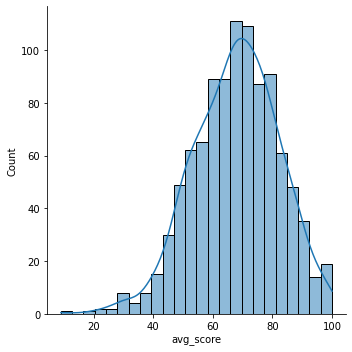

In [5]:
dataframe["avg_score"] = dataframe[['math_score', 'reading_score', 'writing_score']].mean(axis=1)

sns.displot((dataframe.avg_score), kde=True)

In [124]:
def make_groups(column, size=50, by="avg_score", seed=int(time.time())):
    groups = []
    group_names = dataframe[column].unique()
    for group_name in group_names:
        group = dataframe[by][dataframe[column] == group_name].sample(size, random_state=seed)
        groups.append(group)
    return pd.DataFrame(data={f"group{i}": group.values for i, group in enumerate(groups, start=1)})

groups1 = make_groups("race_ethnicity", size=50, by="avg_score")
groups2 = make_groups("parental_level_of_education", size=50, by="avg_score")

In [30]:
groups1.head(5)

,group1,group2,group3,group4,group5
0,59.666667,85.333333,56.0,76.000000,78.666667
1,64.333333,78.000000,64.0,53.333333,55.666667
2,87.000000,39.000000,59.0,73.333333,51.000000
3,81.333333,71.666667,67.0,76.000000,68.000000
4,84.000000,66.333333,59.0,79.333333,80.666667


## (#1) Проверка выборки на независимость (Тест $\chi^2$ Пирсона)

In [18]:
ALHA_SYM = "\u03B1"
alpha = 0.05

_, p_value, _, _ = stats.chi2_contingency(groups1, correction=False)
is_independent = p_value >= alpha

sign = ">=" if is_independent else "<"
print(f"Выборки независимы? {is_independent} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

Выборки независимы? False (p-value=0.000 < α=0.05)


## (#2) Проверка выборки на нормальность распределений (Тест Шапиро-Уилка, тест Краскела-Уоллиса)

In [31]:
alpha = 0.01

for group in groups1.columns:
    _, p_value = stats.shapiro(groups1[group].values)
    is_normal = p_value >= alpha

    sign = ">=" if is_normal else "<"
    print(f"{group} распределена нормально? {is_normal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

group1 распределена нормально? True (p-value=0.121 >= α=0.01)
group2 распределена нормально? True (p-value=0.391 >= α=0.01)
group3 распределена нормально? True (p-value=0.527 >= α=0.01)
group4 распределена нормально? True (p-value=0.648 >= α=0.01)
group5 распределена нормально? True (p-value=0.123 >= α=0.01)


In [32]:
alpha = 0.01

_, p_value = stats.kruskal(*groups1.T.values)
is_equal = p_value >= alpha

sign = ">=" if is_equal else "<"
print(f"Медианы в группах равны? {is_equal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

Медианы в группах равны? False (p-value=0.009 < α=0.01)


## (#3) Проверка гипотезы об однородности дисперсий (Тест Левене)

Дисперсии однородны? True (p-value=0.627 >= α=0.05)


<AxesSubplot:>

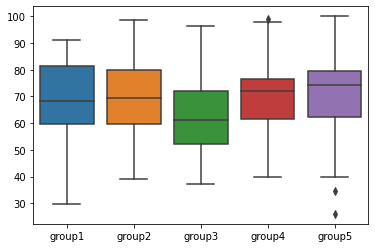

In [33]:
alpha = 0.05

_, p_value = stats.levene(*groups1.T.values)
is_equal = p_value >= alpha

sign = ">=" if is_equal else "<"
print(f"Дисперсии однородны? {is_equal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

sns.boxplot(data=groups1)

## (#4) Средние и стандартные отклонения по группе

In [34]:
means = groups1.mean()
print("Мат. ожидания")
print(means)

stds = groups1.mean()
print("\nСтандартные отклонения")
print(stds)

Мат. ожидания
group1    68.946667
group2    68.446667
group3    62.740000
group4    70.426667
group5    71.340000
dtype: float64

Стандартные отклонения
group1    68.946667
group2    68.446667
group3    62.740000
group4    70.426667
group5    71.340000
dtype: float64


## (#5) Проверка гипотезы о равенстве средних (ANOVA, Analysis of variance)
### Однофакторный - влияние фактора не однозначно

In [35]:
alpha = 0.05

_, p_value = stats.f_oneway(*groups1.T.values)
is_equal = p_value >= alpha

sign = ">=" if is_equal else "<"
print(f"Мат. ожидания однородны? {is_equal} (p-value={p_value:.3f} {sign} {ALHA_SYM}={alpha})")

Мат. ожидания однородны? False (p-value=0.023 < α=0.05)


### Двухфакторный

In [131]:
dataframe.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score', 'avg_score'],
      dtype='object')

In [134]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

variable = "avg_score"
factor1 = "race_ethnicity"
factor2 = "parental_level_of_education"

model = ols(f"{variable} ~ C({factor1}) + C({factor2}) + C({factor1}):C({factor2})", dataframe.sample(200)).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(race_ethnicity),4.0,769.188350,192.297088,0.892798,0.469512
C(parental_level_of_education),4.0,1254.233079,313.558270,1.455790,0.217728
C(race_ethnicity):C(parental_level_of_education),16.0,4890.885836,305.680365,1.419214,0.137202
Residual,175.0,37692.732179,215.387041,NaN,NaN


Вывод:
- Факторы по отдельности имеют существенное влияние на зависимую переменную.
- Два фактора вместе не оказывают существенного влияния на зависимую переменную.

## (#6) Как группы различаются между собой? (Тест Тьюки)

In [36]:
stacked = groups1.stack().reset_index()
stacked = stacked.rename(columns={
    "level_0": "id",
    "level_1": "group",
    0: "result",
})

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
group1 group2     -0.5    0.9  -8.1772  7.1772  False
group1 group3  -6.2067  0.175 -13.8838  1.4705  False
group1 group4     1.48    0.9  -6.1972  9.1572  False
group1 group5   2.3933    0.9  -5.2838 10.0705  False
group2 group3  -5.7067 0.2488 -13.3838  1.9705  False
group2 group4     1.98    0.9  -5.6972  9.6572  False
group2 group5   2.8933 0.8174  -4.7838 10.5705  False
group3 group4   7.6867 0.0495   0.0095 15.3638   True
group3 group5      8.6 0.0195   0.9228 16.2772   True
group4 group5   0.9133    0.9  -6.7638  8.5905  False
-----------------------------------------------------


C:\Users\igork\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


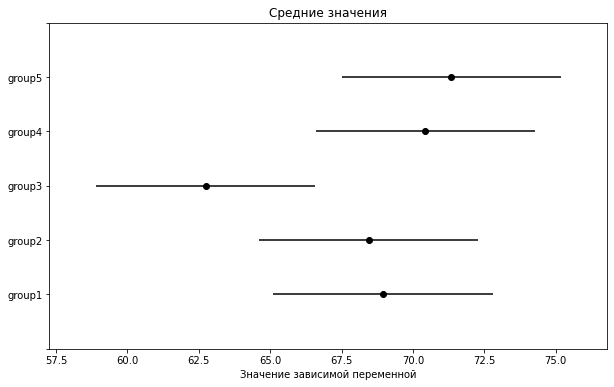

In [38]:
alpha = 0.05

multi_comparison = MultiComparison(stacked['result'], stacked['group'])
results = multi_comparison.tukeyhsd(alpha)

print(results.summary())

fig = results.plot_simultaneous(xlabel='Значение зависимой переменной')
fig.get_axes()[0].title.set_text('Средние значения')

Видно, что значения доверительного интервала среднего значения в третьей группе значительно отличается от других.

## Вывод:
В ходе выполнения лабораторной работы было осуществлено знакомство с теоретическими основами дисперсионного анализа, сформированы навыки выполнения многофакторного дисперсионного анализа с помощью языка программирования Python.